In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score

def adj_r2_score(r2, n, k):
    return 1-((1-r2)*((n-1)/(n-k-1)))

In [2]:
exchange_data = pd.read_pickle('VIX_quandl.pk')
print(exchange_data.index)
exchange_data["Date"] = pd.to_datetime(exchange_data.index)
ind_exchange_data = exchange_data.set_index(["Date"], drop=True)

DatetimeIndex(['2004-01-02', '2004-01-05', '2004-01-06', '2004-01-07',
               '2004-01-08', '2004-01-09', '2004-01-12', '2004-01-13',
               '2004-01-14', '2004-01-15',
               ...
               '2018-08-07', '2018-08-08', '2018-08-09', '2018-08-10',
               '2018-08-13', '2018-08-14', '2018-08-15', '2018-08-16',
               '2018-08-17', '2018-08-20'],
              dtype='datetime64[ns]', name='Date', length=3684, freq=None)


### Real DataFrame

In [3]:
ind_exchange_data.head()

,VIX Open,VIX High,VIX Low,VIX Close
Date,,,,
2004-01-02,17.96,18.68,17.54,18.22
2004-01-05,18.45,18.49,17.44,17.49
2004-01-06,17.66,17.67,16.19,16.73
2004-01-07,16.72,16.75,15.50,15.50
2004-01-08,15.42,15.68,15.32,15.61


### Reversed and Flipped DataFrame

In [4]:
data_frame = ind_exchange_data.sort_index(axis=1 ,ascending=True)
# data_frame = data_frame.iloc[::-1]
data_frame.head()

,VIX Close,VIX High,VIX Low,VIX Open
Date,,,,
2004-01-02,18.22,18.68,17.54,17.96
2004-01-05,17.49,18.49,17.44,18.45
2004-01-06,16.73,17.67,16.19,17.66
2004-01-07,15.50,16.75,15.50,16.72
2004-01-08,15.61,15.68,15.32,15.42


In [5]:
df = data_frame[["VIX Close"]]

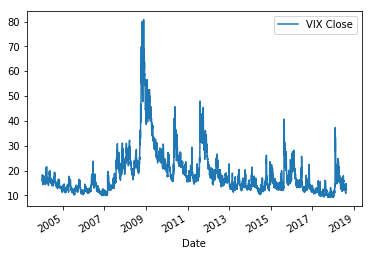

In [6]:
df.plot()

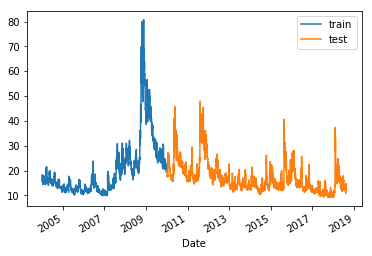

In [7]:
split_date = pd.Timestamp('01-01-2010')

train = df.loc[:split_date]
test = df.loc[split_date:]

ax = train.plot()
test.plot(ax=ax)
plt.legend(['train', 'test'])

In [8]:
sc = MinMaxScaler()
train_sc = sc.fit_transform(train)
test_sc = sc.transform(test)

# Non-Shifted

## ANN

In [9]:
X_train = train_sc[:-1]
y_train = train_sc[1:]

X_test = test_sc[:-1]
y_test = test_sc[1:]

In [10]:
from keras.models import Sequential
from keras.layers import Dense
import keras.backend as K
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.models import load_model


Using Theano backend.


In [32]:
#K.clear_session()

model = Sequential()
model.add(Dense(12, input_dim=1, activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
early_stop = EarlyStopping(monitor='loss', patience=2, verbose=1)
history = model.fit(X_train, y_train, epochs=200, batch_size=1, verbose=1, callbacks=[early_stop], shuffle=False)

AttributeError: module 'keras.backend' has no attribute 'clear_session'

In [12]:
y_pred_test_ann = model.predict(X_test)
y_train_pred_ann = model.predict(X_train)
print("The R2 score on the Train set is:\t{:0.3f}".format(r2_score(y_train, y_train_pred_ann)))
r2_train = r2_score(y_train, y_train_pred_ann)
print("The Adjusted R2 score on the Train set is:\t{:0.3f}\n".format(adj_r2_score(r2_train, X_train.shape[0], X_train.shape[1])))
print("The R2 score on the Test set is:\t{:0.3f}".format(r2_score(y_test, y_pred_test_ann)))
r2_test = r2_score(y_test, y_pred_test_ann)
print("The Adjusted R2 score on the Test set is:\t{:0.3f}".format(adj_r2_score(r2_test, X_test.shape[0], X_test.shape[1])))

The R2 score on the Train set is:	0.901
The Adjusted R2 score on the Train set is:	0.901

The R2 score on the Test set is:	0.852
The Adjusted R2 score on the Test set is:	0.852


In [13]:
model.save('ANN_NonShift.h5')

### Process the data for LSTM

In [14]:
X_tr_t = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_tst_t = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

## LSTM

In [24]:
from keras.layers import LSTM
from keras import backend as K
#K.clear_session
model_lstm = Sequential()
model_lstm.add(LSTM(4, input_shape=(1, X_train.shape[1]), activation='relu', kernel_initializer='lecun_uniform', return_sequences=False))
model_lstm.add(Dense(1))
model_lstm.compile(loss='mean_squared_error', optimizer='adam')
early_stop = EarlyStopping(monitor='loss', patience=5, verbose=1)
history_model_lstm = model_lstm.fit(X_tr_t, y_train, epochs=200, batch_size=1, verbose=1, shuffle=False, callbacks=[early_stop])

y_pred_test_lstm = model_lstm.predict(X_tst_t)
y_train_pred_lstm = model_lstm.predict(X_tr_t)
print("The R2 score on the Train set is:\t{:0.3f}".format(r2_score(y_train, y_train_pred_lstm)))
r2_train = r2_score(y_train, y_train_pred_lstm)
print("The Adjusted R2 score on the Train set is:\t{:0.3f}\n".format(adj_r2_score(r2_train, X_train.shape[0], X_train.shape[1])))
print("The R2 score on the Test set is:\t{:0.3f}".format(r2_score(y_test, y_pred_test_lstm)))
r2_test = r2_score(y_test, y_pred_test_lstm)
print("The Adjusted R2 score on the Test set is:\t{:0.3f}".format(adj_r2_score(r2_test, X_test.shape[0], X_test.shape[1])))

Epoch 1/200
1510/1510 [==============================] - 1s 890us/step - loss: 0.0014
Epoch 2/200
1510/1510 [==============================] - 1s 890us/step - loss: 0.0010
Epoch 3/200
1510/1510 [==============================] - 1s 914us/step - loss: 9.7905e-04
Epoch 4/200
1510/1510 [==============================] - 1s 895us/step - loss: 9.5269e-04
Epoch 5/200
1510/1510 [==============================] - 1s 901us/step - loss: 9.3304e-04
Epoch 6/200
1510/1510 [==============================] - 1s 874us/step - loss: 9.1718e-04
Epoch 7/200
1510/1510 [==============================] - 1s 880us/step - loss: 9.0239e-04
Epoch 8/200
1510/1510 [==============================] - 1s 882us/step - loss: 8.8947e-04
Epoch 9/200
1510/1510 [==============================] - 1s 879us/step - loss: 8.7551e-04
Epoch 10/200
1510/1510 [==============================] - 1s 894us/step - loss: 8.6056e-04
Epoch 11/200
1510/1510 [==============================] - 1s 903us/step - loss: 8.4627e-04
Epoch 12/200
151

In [25]:
model_lstm.save('LSTM_NonShift.h5')

## Predictions made by each Model

In [26]:
model_ann = load_model('ANN_NonShift.h5')
model_lstm = load_model('LSTM_NonShift.h5')

In [27]:
score_ann= model_ann.evaluate(X_test, y_test, batch_size=1)
score_lstm= model_lstm.evaluate(X_tst_t, y_test, batch_size=1)

2172/2172 [==============================] - 0s 228us/step


In [28]:
print('ANN: %f'%score_ann)
print('LSTM: %f'%score_lstm)

ANN: 0.001007
LSTM: 0.001016


In [29]:
y_pred_test_ANN = model_ann.predict(X_test)
y_pred_test_LSTM = model_lstm.predict(X_tst_t)

In [30]:
col1 = pd.DataFrame(y_test, columns=['True'])
col2 = pd.DataFrame(y_pred_test_ANN, columns=['ANN_prediction'])
col3 = pd.DataFrame(y_pred_test_LSTM, columns=['LSTM_prediction'])
col4 = pd.DataFrame(history.history['loss'], columns=['Loss_ANN'])
col5 = pd.DataFrame(history_model_lstm.history['loss'], columns=['Loss_LSTM'])
results = pd.concat([col1, col2, col3, col4, col5], axis=1)
results.to_csv('PredictionResults_ANN-LSTM_NonShift.csv')

### ANN's Prediction Visual

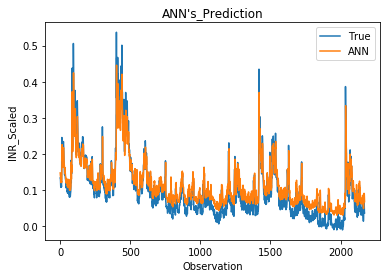

In [31]:
plt.plot(y_test, label='True')
plt.plot(y_pred_test_ANN, label='ANN')
plt.title("ANN's_Prediction")
plt.xlabel('Observation')
plt.ylabel('INR_Scaled')
plt.legend()
plt.show()

### LSTM's Prediction Visual

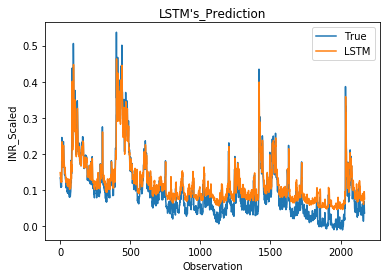

In [23]:
plt.plot(y_test, label='True')
plt.plot(y_pred_test_LSTM, label='LSTM')
plt.title("LSTM's_Prediction")
plt.xlabel('Observation')
plt.ylabel('INR_Scaled')
plt.legend()
plt.show()